<a href="https://colab.research.google.com/github/smccracken13/Zestimate-Project/blob/main/Zestimate_Data_Wrangling_(2016_data_only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Zestimate Data Wrangling
https://www.kaggle.com/competitions/zillow-prize-1

Scott McCracken

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Load the data sets from Kaggle
There is data from two home selling seasons: 2016 and 2017. Each season has a train.csv that includes transaction dates and log error (the error that the Zestimate had) and a properties.csv that contains home features. Eventually, we will need to predict logerror.

# File descriptions
prop16 - all the properties with their home features for 2016.

train16 - the training set with transactions from 1/1/2016 to 12/31/2016

sample_submission.csv - a sample submission file in the correct format

In [3]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"getitcracken","key":"1738535d0942e470367a3e2f5eab5c24"}'}

In [4]:
# I will load the datasets directly from Kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# prop16 contains property features for most of 2016
!kaggle competitions download -c zillow-prize-1 -f properties_2016.csv
!unzip properties_2016.csv.zip
prop16 = pd.read_csv('properties_2016.csv', low_memory=False)

properties_2016.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  properties_2016.csv.zip
replace properties_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: properties_2016.csv     


In [89]:
# train16 contains parcel_id, transaction dates, and logerror for most of 2016
!kaggle competitions download -c zillow-prize-1 -f train_2016_v2.csv
!unzip train_2016_v2.csv.zip
train16 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)

train_2016_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_2016_v2.csv.zip
replace train_2016_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
!kaggle competitions download -c zillow-prize-1 -f sample_submission.csv
!unzip sample_submission.csv.zip
sample_submit = pd.read_csv('sample_submission.csv', low_memory=False)

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Peek at sample_submit
For the competition, participants are asked to predict the logerror for each home at 6 dates: Oct 2016, Nov 2016, Dec 2016, Oct 2017, Nov 2017, Dec 2017. 

In [8]:
sample_submit.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


# Shape of each dataframe

In [9]:
print("Prop16 shape:", prop16.shape)
print("Train16 shape:", train16.shape)
print('Sample shape:', sample_submit.shape)

Prop16 shape: (2985217, 58)
Train16 shape: (90275, 3)
Sample shape: (2985217, 7)


# Peek at train16

In [10]:
train16.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [11]:
print('Non unique parcelid rows for 2016:', 90275 - train16['parcelid'].nunique())
(train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

Non unique parcelid rows for 2016: 125


1    90026
2      123
3        1
Name: parcelid, dtype: int64

In [12]:
# First and last tranaction dates
print("First Transaction 2016:", train16['transactiondate'].min())
print("Last Transaction 2016:", train16['transactiondate'].max())

First Transaction 2016: 2016-01-01 00:00:00
Last Transaction 2016: 2016-12-30 00:00:00


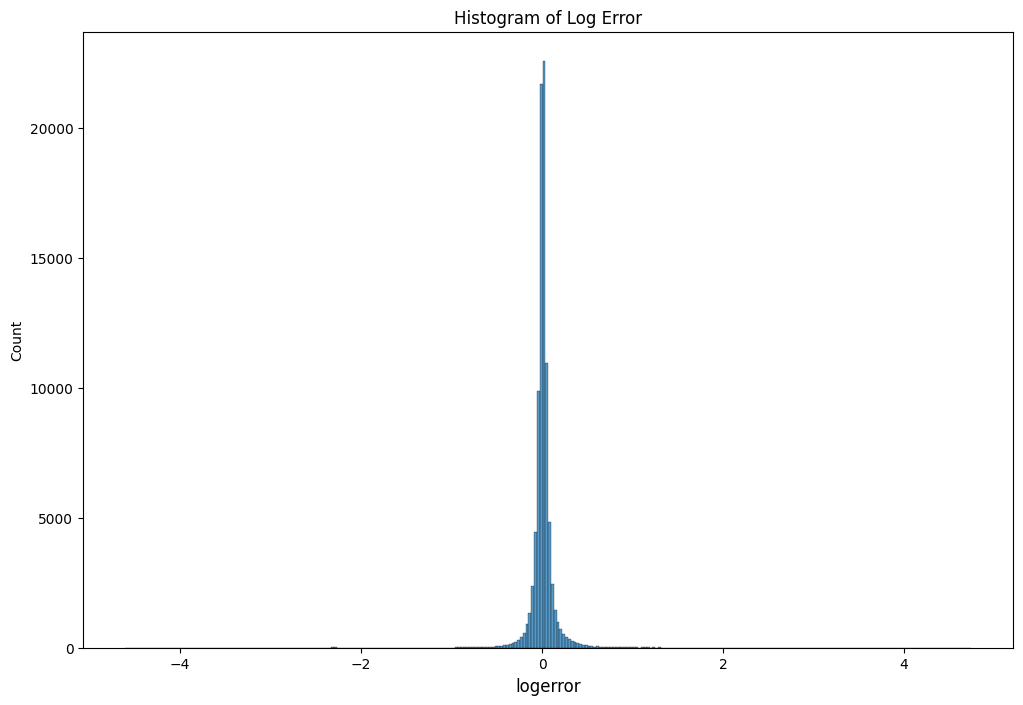

In [13]:
plt.figure(figsize=(12,8))
sns.histplot(train16.logerror.values, bins=300, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.title('Histogram of Log Error')
plt.show()

In [14]:
print("Worst negative logerror:", train16['logerror'].min())
print("Worst positive logerror:", train16['logerror'].max())

Worst negative logerror: -4.605
Worst positive logerror: 4.737


Check for null in transaction data

In [15]:
missing = pd.concat([train16.isnull().sum(), 100 * train16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
parcelid,0,0.0
logerror,0,0.0
transactiondate,0,0.0


# Peek at properties dataframes

In [16]:
prop16.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


# Peek at some of the high null % columns, like storytypeid and basementsqft

# Rename columns to make more sense

In [19]:
# Create dictionary to rename columns in a way that makes more sense
rename_col_dict = {
    'yardbuildingsqft17' : 'patio_sqft',
    'yardbuildingsqft26' : 'shed_sqft' ,
    'lotsizesquarefeet' : 'lot_sqft', 
    'garagetotalsqft' : 'garage_sqft',
    'finishedfloor1squarefeet' : 'entry_floor_sqft',
    'calculatedfinishedsquarefeet' : 'home_sqft',
    'finishedsquarefeet6' : 'base_sqft',
    'finishedsquarefeet12' : 'living_sqft',
    'finishedsquarefeet13' : 'perimeter_sqft',
    'finishedsquarefeet15' : 'total_sqft',
    'regionidcounty' : 'county',
    'regionidcity' : 'city',
    'regionidzip' : 'zipcode',
    'regionidneighborhood' : 'neighborhood',
    'taxvaluedollarcnt' : 'tax_assessed_value',
    'structuretaxvaluedollarcnt' : 'tav_built',
    'landtaxvaluedollarcnt' : 'tav_land',
    'taxamount' : 'property_tax',
    'propertyzoningdesc' : 'zoning_code',
    'propertycountylandusecode' : 'land_use_code',
    'propertylandusetypeid' : 'county_land_use_code',
    'hashottuborspa' : 'has_spa',
    'buildingqualitytypeid' : 'quality',
    'buildingclasstypeid' : 'framing',
    'typeconstructiontypeid' : 'material',
    'decktypeid' : 'deck',
    'heatingorsystemtypeid' : 'heating',
    'airconditioningtypeid' : 'aircon',
    'architecturalstyletypeid' : 'architecture',
    'pooltypeid2' : 'pool_with_spa',
    'pooltypeid7' : 'pool_without_spa',
    'pooltypeid10' : 'spa_or_hot_tub'}
prop16.rename(columns=rename_col_dict, inplace=True, errors = 'raise')

In [20]:
prop16.columns

Index(['parcelid', 'aircon', 'architecture', 'basementsqft', 'bathroomcnt',
       'bedroomcnt', 'framing', 'quality', 'calculatedbathnbr', 'deck',
       'entry_floor_sqft', 'home_sqft', 'living_sqft', 'perimeter_sqft',
       'total_sqft', 'finishedsquarefeet50', 'base_sqft', 'fips',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garage_sqft', 'has_spa',
       'heating', 'latitude', 'longitude', 'lot_sqft', 'poolcnt',
       'poolsizesum', 'spa_or_hot_tub', 'pool_with_spa', 'pool_without_spa',
       'land_use_code', 'county_land_use_code', 'zoning_code',
       'rawcensustractandblock', 'city', 'county', 'neighborhood', 'zipcode',
       'roomcnt', 'storytypeid', 'threequarterbathnbr', 'material', 'unitcnt',
       'patio_sqft', 'shed_sqft', 'yearbuilt', 'numberofstories',
       'fireplaceflag', 'tav_built', 'tax_assessed_value', 'assessmentyear',
       'tav_land', 'property_tax', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'censustractandblock'],
      dtype='obje

# Identify categorical data

Categorical Data that have codes in the data dictionary

In [21]:
print('Categorical data with codes in the data dictionary.')
print('Heating:', prop16.heating.unique())
print('Heating codes are in the data dictionary')
print()
print('AirCon:', prop16.aircon.unique())
print('AirCon codes are in the data dictionary')
print()
print('Framing:', prop16.framing.unique())
print('Framing codes are in the data dictionary')
print()
print('Material:', prop16.material.unique())
print('Material codes are in the data dictionary')
print()
print('Architecture:', prop16.architecture.unique())
print('Architecture codes are in the data dictionary')
print()
print('# of uniques for land use:', prop16['land_use_code'].nunique())
print('Land Use examples:', prop16['land_use_code'].unique())
print('Land Use codes are in the data dictionary')
print()
print('The other feature in the data dicitionary is "storytypeid," which is either NaN or 7 for "basement."')
print()
print('FIPS:', prop16.fips.unique())
print('FIPS explained here: https://en.wikipedia.org/wiki/FIPS_county_code')

Categorical data with codes in the data dictionary.
Heating: [nan  2.  7. 20.  6. 13. 18. 24. 12. 10.  1. 14. 21. 11. 19.]
Heating codes are in the data dictionary

AirCon: [nan  1. 13.  5. 11.  9. 12.  3.]
AirCon codes are in the data dictionary

Framing: [nan  3.  4.  5.  2.  1.]
Framing codes are in the data dictionary

Material: [nan  6.  4. 10. 13. 11.]
Material codes are in the data dictionary

Architecture: [nan  7. 21.  8.  2.  3.  5. 10. 27.]
Architecture codes are in the data dictionary

# of uniques for land use: 240
Land Use examples: ['010D' '0109' '1200' '1210' '010V' '300V' '0100' '0200' '010C' '0300'
 '1204' '100V' '01HC' '120C' '040V' '1214' '0101' nan '070P' '0700' '1'
 '128' '0' '1112' '5050' '1110' '1118' '010E' '1111' '1129' '1420' '1222'
 '1128' '1310' '1117' '1333' '1116' '1410' '0104' '070D' '0108' '012C'
 '0400' '0103' '01DC' '0201' '010M' '030V' '0110' '010F' '010G' '010H'
 '0301' '0102' '020E' '020M' '0401' '0113' '0141' '122' '38' '135' '96'
 '71' '73' '34' 

In [22]:
# Other categorical data
print('# of uniques for zoning desc:', prop16['zoning_code'].nunique())
print('Zoning examples:', prop16.zoning_code.unique())
print()
print('Quality:', prop16.quality.unique())
print()
print('Deck:', prop16.deck.unique())

# of uniques for zoning desc: 5638
Zoning examples: [nan 'LCA11*' 'LAC2' ... 'WCR1400000' 'EMPYYY' 'RMM2*']

Quality: [nan  7.  4. 10.  1. 12.  8.  3.  6.  9.  5. 11.  2.]

Deck: [nan 66.]


In [65]:
# Boolean data
print('Has Spa:', prop16.has_spa.unique()) #originally called hastuborspa
print()
print('Has Spa #2', prop16['spa_or_hot_tub'].unique()) #originally called pooltypeid10
print()
print('Pool with spa', prop16['pool_with_spa'].unique())
print()
print('Pool without spa', prop16['pool_without_spa'].unique())
print()
print('Tax Deliquency Flag:', prop16['taxdelinquencyflag'].unique())
print()
print('Has Fireplace', prop16['fireplaceflag'].unique())

Has Spa: [nan  1.]

Has Spa #2 [nan  1.]

Pool with spa [nan  1.]

Pool without spa [nan  1.]

Tax Deliquency Flag: [nan  1.]

Has Fireplace [nan  1.]


In [24]:
# Tax deliquency column
print('Percent of properties flagged as tax deliquent:', 100*prop16[prop16['taxdelinquencyflag'].notnull()]['taxdelinquencyflag'].count()/prop16.shape[0])
print('These have a "Y", only other values are NaN')

Percent of properties flagged as tax deliquent: 1.8913867903070363
These have a "Y", only other values are NaN


In [25]:
# Change 'Y' to 1 for tax deliquency flag column
prop16['taxdelinquencyflag'].replace(to_replace='Y',value=1, inplace=True)

In [44]:
# Change True to 1 for 'has_spa' and 'fireplaceflag' columns
prop16['has_spa'].replace(to_replace=True,value=1, inplace=True)
prop16['fireplaceflag'].replace(to_replace=True,value=1, inplace=True)

In [27]:
# Tax Deliquency Year
print('Tax Delinquency Year:', prop16['taxdelinquencyyear'].sort_values().unique())

Tax Delinquency Year: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 79. 82.
 84. 86. 87. 88. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99. nan]


In [28]:
# The description for Tax Deliquency Year in the data dictionary reads: "Year for which the unpaid propert taxes were due."
# note that values are all below 16 or much much higher
# It seems like these values should instead be 0 = 2000, 1 = 2001, etc. and 84 = 1984, 86 = 1986, etc.
delinq_year_dict = {0:2000, 1:2001, 2:2002, 3:2003, 4:2004, 5:2005, 6:2006, 7:2007, 8:2008, 9:2009, 10:2010, 11:2011, 12:2012, 13:2013, 14:2014, 15:2015, \
                    79:1979, 82:1982, 84:1984, 86:1986, 87:1987, 88:1988, 90:1990, 91:1991, 92:1992, 93:1993, 94:1994, 95:1995, 96:1996, 97:1997, 98:1998, 99:1999}
prop16['taxdelinquencyyear'].replace(delinq_year_dict, inplace=True)
print('Tax Delinquency Year:', prop16['taxdelinquencyyear'].sort_values().unique())

Tax Delinquency Year: [1979. 1982. 1984. 1986. 1987. 1988. 1990. 1991. 1992. 1993. 1994. 1995.
 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.   nan]


In [29]:
# test todateime, I could use this to convert columns with yearly data
test = pd.DataFrame(data={'taxyear':[1999,2000,2005,2016]})
pd.to_datetime(test['taxyear'], format='%Y')

0   1999-01-01
1   2000-01-01
2   2005-01-01
3   2016-01-01
Name: taxyear, dtype: datetime64[ns]

In [30]:
# Year built
print('Oldest home:', prop16.yearbuilt.min())
print('Newest home:', prop16.yearbuilt.max())
# Should I change this to age by computing 2016 - yearbuilt?

Oldest home: 1801.0
Newest home: 2015.0


In [31]:
# Assessment Year
print('Assessment Year values:', prop16.assessmentyear.unique())
print('Oldest:', prop16.assessmentyear.min())
print('Newest:', prop16.assessmentyear.max())
# Should I change this to categorical? only 14 values

Assessment Year values: [2015. 2014. 2003. 2012. 2001. 2011. 2013. 2016. 2010.   nan 2004. 2005.
 2002. 2000. 2009.]
Oldest: 2000.0
Newest: 2016.0


# Duplicate columns

In [26]:
# What is the difference between these two spa columns?
print('Has Spa count:', prop16.has_spa.notnull().sum()) #originally called hastuborspa
print('Has Spa #2 count:', prop16['spa_or_hot_tub'].notnull().sum()) #originally called pooltypeid10

Has Spa count: 69014
Has Spa #2 count: 36939


In [105]:
prop16[prop16['has_spa'].notnull()][['has_spa','spa_or_hot_tub']]

,has_spa,spa_or_hot_tub
1340,1.0,1.0
1341,1.0,1.0
1497,1.0,1.0
1691,1.0,1.0
1694,1.0,1.0
...,...,...
2973008,1.0,NaN
2973193,1.0,1.0
2973636,1.0,NaN
2973644,1.0,1.0


In [111]:
prop16[prop16['spa_or_hot_tub'].notnull()]['has_spa'].unique()
# every record that =1 for 'spa_or_hot_tub' already has a 1 in 'has_spa'
# 'spa_or_hot_tub' gives no new information, it can be dropped

array([1.])

In [112]:
prop16.drop(columns=['spa_or_hot_tub'], inplace=True)

In [103]:
# I noticed a second duplicate column: 'finishedsquarefeet50' is the same description as 'entry_floor_sqft'
prop16[prop16['entry_floor_sqft'].notnull()][['entry_floor_sqft','finishedsquarefeet50']]
# they have equivalent values, drop finishedsqurefeet50

,entry_floor_sqft,finishedsquarefeet50
295,4969.0,4969.0
296,1080.0,1080.0
297,780.0,780.0
298,1250.0,1250.0
299,1404.0,1404.0
...,...,...
2973692,1358.0,1358.0
2973693,640.0,640.0
2973706,710.0,710.0
2973735,707.0,707.0


In [104]:
prop16.drop(columns=['finishedsquarefeet50'], inplace=True)

# Look into census, tract, county and city codes

In [49]:
print(prop16[prop16['censustractandblock'].notnull()][['rawcensustractandblock','censustractandblock']].head())

     rawcensustractandblock  censustractandblock
295            6.111001e+07         6.111001e+13
296            6.111001e+07         6.111001e+13
297            6.111001e+07         6.111001e+13
298            6.111001e+07         6.111001e+13
299            6.111001e+07         6.111001e+13


In [50]:
print('Raw Cenus Tract and Block:', prop16.iloc[295]['rawcensustractandblock'])
print('Cenus Tract and Block:', prop16.iloc[295]['censustractandblock'])
print('FIPS code:', prop16.iloc[295]['fips'])
# California 6
# Ventura County 111
# Tract 0010.01
# Block 10123 ?
# https://www.ffiec.gov/census/report.aspx?year=2016&county=111&tract=0010.01&state=06&report=demographic

Raw Cenus Tract and Block: 61110010.011023
Cenus Tract and Block: 61110010011023.0
FIPS code: 6111.0


In [52]:
prop16['fips'].unique()
# 6037 = Los Angeles
# 6059 = Orange
# 6111 = Ventura

array([6037., 6059., 6111.,   nan])

In [54]:
# Check a record we know is Ventura County
prop16.iloc[295][['fips','county','city']]

fips       6111.0
county     2061.0
city      13091.0
Name: 295, dtype: object

In [58]:
# check a record we know is Orange County
prop16.iloc[245][['fips','county','city']]

fips       6059.0
county     1286.0
city      24812.0
Name: 245, dtype: object

In [56]:
prop16['county'].unique()
# county 2061 = Ventura
# county 1286 = Orange
# county 31031 = Los Angeles

array([3101., 1286., 2061.,   nan])

In [61]:
print('Number of cities:', prop16['city'].nunique())
print('Number of neighborhoods:', prop16['neighborhood'].nunique())

Number of cities: 186
Number of neighborhoods: 528


In [62]:
prop16.columns

Index(['parcelid', 'aircon', 'architecture', 'basementsqft', 'bathroomcnt',
       'bedroomcnt', 'framing', 'quality', 'calculatedbathnbr', 'deck',
       'entry_floor_sqft', 'home_sqft', 'living_sqft', 'perimeter_sqft',
       'total_sqft', 'finishedsquarefeet50', 'base_sqft', 'fips',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garage_sqft', 'has_spa',
       'heating', 'latitude', 'longitude', 'lot_sqft', 'poolcnt',
       'poolsizesum', 'spa_or_hot_tub', 'pool_with_spa', 'pool_without_spa',
       'land_use_code', 'county_land_use_code', 'zoning_code',
       'rawcensustractandblock', 'city', 'county', 'neighborhood', 'zipcode',
       'roomcnt', 'storytypeid', 'threequarterbathnbr', 'material', 'unitcnt',
       'patio_sqft', 'shed_sqft', 'yearbuilt', 'numberofstories',
       'fireplaceflag', 'tav_built', 'tax_assessed_value', 'assessmentyear',
       'tav_land', 'property_tax', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'censustractandblock'],
      dtype='obje

In [63]:
prop16['pool_with_spa'].unique()

array([nan,  1.])

In [33]:
categorical_columns = ['aircon', 'architecture', 'framing', 'quality', 'deck',
                       'fips', 'heating', 'latitude', 'longitude', 'rawcensustractandblock', 
                       'city', 'county', 'neighborhood', 'zipcode', 'storytypeid', 
                       'material', 'unitcnt', 'numberofstories', 'assessmentyear',
                       'taxdelinquencyyear', 'censustractandblock']

boolean_columns = ['has_spa', 'spa_or_hot_tub', 'pool_with_spa', 'pool_without_spa', 'fireplaceflag', 'taxdeliquencyflag']

# assessmentyear and taxdelinquencyyear are not necessarily categorical
# yearbuilt could be changed to age

# Examine null values
A lot of the columns have high percentages of null values.

Number of columns with <10% null: 25

Number of columns with >33% null: 33

In [34]:
missing = pd.concat([prop16.isnull().sum(), 100 * prop16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
storytypeid,2983593,99.945599
basementsqft,2983589,99.945465
shed_sqft,2982570,99.911330
fireplaceflag,2980054,99.827048
architecture,2979156,99.796966
material,2978470,99.773986
perimeter_sqft,2977545,99.743000
framing,2972588,99.576949
deck,2968121,99.427311
base_sqft,2963216,99.263002


In [35]:
print('# of columns with <10% null:', missing[missing['% null']<10]['% null'].count())
print('# of columns with >33% null:', missing[missing['% null']>33]['% null'].count())

# of columns with <10% null: 25
# of columns with >33% null: 33


In [78]:
# There are 11,437 records that are completely null except parcelid
prop16[prop16['latitude'].isnull()].isnull().values.sum(axis=1)

array([57, 57, 57, ..., 57, 57, 57])

In [17]:
print('Values for storytypeid:', prop16.storytypeid.unique(), '7 = "Basement"')
print('Count for "Basement":', prop16[prop16.storytypeid.notnull()==True]['storytypeid'].count())
# Can I infer this means, does it have a basement or not? I don't think so. 1624 out of nearly 3 mil is too low for basement counts.

Values for storytypeid: [nan  7.] 7 = "Basement"
Count for "Basement": 1624


In [18]:
# basement square footage column
print(prop16[prop16.storytypeid.notnull()==True]['basementsqft'].min())
print(prop16[prop16.storytypeid.notnull()==True]['basementsqft'].max())

20.0
8516.0


This function could be used to parse the dates

In [88]:
# Function to get more specific features from transaction dates
def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = df["transactiondate"].dt.quarter
    return df

In [90]:
add_date_features(train16)

,parcelid,logerror,transactiondate,transaction_year,transaction_month,transaction_day,transaction_quarter
0,11016594,0.0276,2016-01-01,2016,1,1,1
1,14366692,-0.1684,2016-01-01,2016,1,1,1
2,12098116,-0.0040,2016-01-01,2016,1,1,1
3,12643413,0.0218,2016-01-02,2016,1,2,1
4,14432541,-0.0050,2016-01-02,2016,1,2,1
...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,2016,12,30,4
90271,12046695,0.0070,2016-12-30,2016,12,30,4
90272,12995401,-0.2679,2016-12-30,2016,12,30,4
90273,11402105,0.0602,2016-12-30,2016,12,30,4


# Merge properties data to transaction data

In [113]:
df16 = pd.merge(train16, prop16, how='left', on='parcelid')

In [114]:
df16

,parcelid,logerror,transactiondate,transaction_year,transaction_month,transaction_day,transaction_quarter,aircon,architecture,basementsqft,...,numberofstories,fireplaceflag,tav_built,tax_assessed_value,assessmentyear,tav_land,property_tax,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,2016,1,1,1,1.0,NaN,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,2016,1,1,1,NaN,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,2016,1,1,1,1.0,NaN,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,2016,1,2,1,1.0,NaN,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,2016,1,2,1,NaN,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,2016,12,30,4,1.0,NaN,NaN,...,NaN,NaN,43800.0,191000.0,2015.0,147200.0,2495.24,NaN,NaN,6.037132e+13
90271,12046695,0.0070,2016-12-30,2016,12,30,4,NaN,NaN,NaN,...,NaN,NaN,117893.0,161111.0,2015.0,43218.0,1886.54,NaN,NaN,6.037301e+13
90272,12995401,-0.2679,2016-12-30,2016,12,30,4,NaN,NaN,NaN,...,NaN,NaN,22008.0,38096.0,2015.0,16088.0,1925.70,1.0,2014.0,6.037433e+13
90273,11402105,0.0602,2016-12-30,2016,12,30,4,NaN,NaN,NaN,...,NaN,NaN,132991.0,165869.0,2015.0,32878.0,2285.57,NaN,NaN,6.037601e+13


In [115]:
pd.set_option('display.max_rows', 70)
missing = pd.concat([df16.isnull().sum(), 100 * df16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
framing,90259,99.982276
perimeter_sqft,90242,99.963445
basementsqft,90232,99.952368
storytypeid,90232,99.952368
shed_sqft,90180,99.894766
fireplaceflag,90053,99.754085
architecture,90014,99.710883
material,89976,99.668790
base_sqft,89854,99.533647
deck,89617,99.271116


In [116]:
print('# of columns with <2% null:', missing[missing['% null']<2]['% null'].count())
print('# of columns with >33% null:', missing[missing['% null']>33]['% null'].count())

# of columns with <2% null: 29
# of columns with >33% null: 31


In [119]:
print(len(df16.columns))
df16.columns

62


Index(['parcelid', 'logerror', 'transactiondate', 'transaction_year',
       'transaction_month', 'transaction_day', 'transaction_quarter', 'aircon',
       'architecture', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'framing',
       'quality', 'calculatedbathnbr', 'deck', 'entry_floor_sqft', 'home_sqft',
       'living_sqft', 'perimeter_sqft', 'total_sqft', 'base_sqft', 'fips',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garage_sqft', 'has_spa',
       'heating', 'latitude', 'longitude', 'lot_sqft', 'poolcnt',
       'poolsizesum', 'pool_with_spa', 'pool_without_spa', 'land_use_code',
       'county_land_use_code', 'zoning_code', 'rawcensustractandblock', 'city',
       'county', 'neighborhood', 'zipcode', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'material', 'unitcnt', 'patio_sqft', 'shed_sqft',
       'yearbuilt', 'numberofstories', 'fireplaceflag', 'tav_built',
       'tax_assessed_value', 'assessmentyear', 'tav_land', 'property_tax',
       'taxdelinquen

In [120]:
from google.colab import files
df16.to_csv('zillow16.csv', encoding = 'utf-8-sig') 
files.download('zillow16.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>